In [13]:
from concurrent.futures import ThreadPoolExecutor
import requests
import os
import glob
import re
from datetime import date

from Parsers.parsers import TURBD

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin, urlparse

### Parse raw recovered host data

In [14]:
savepath = os.path.abspath("C:/Users/kylene.cooley/ast3_turbidity_data/")
def download_file(url, savepath=savepath):
    response = requests.get(url)
    if response.status_code == 200:
        filename = response.url.split("/")[-1]
    else:
        filename = url.split("/")[-1]
    with open(savepath+"/"+filename, mode="wb") as file:
        file.write(response.content)
    print(f"Downloaded file {filename}")

In [2]:
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/turbd"
response = requests.get(url, stream=True)
response.url

'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/turbd/'

In [3]:
response.content

b'<HTML>\n<HEAD>\n<SCRIPT>\nfunction help() {\n        window.open(\'http://oceanobservatories.org/data/raw-data/\',\'HELP\',\'height=1024,width=1280,menubar=no,scrollbars=yes,status=no,toolbar=no,left=100,top=100\');\n}\n</SCRIPT>\n<link rel="stylesheet" type="text/css" href="/style.css"\n</HEAD>\n<BODY>\n<CENTER><IMG SRC="/header.jpg" width="100%" height="auto"><BR><BR><A HREF="javascript:help();">Documentation</A><BR><BR></CENTER>\n<pre><img src="/icons/blank.gif" alt="Icon "> <a href="?C=N;O=D">Name</a>                                  <a href="?C=M;O=A">Last modified</a>      <a href="?C=S;O=A">Size</a>  <a href="?C=D;O=A">Description</a><hr><img src="/folder-home.png" alt="[PARENTDIR]"> <a href="/files/AS03CPSM/R00001/cg_data/dcl16/">Parent Directory</a>                                           -   \n<img src="/icons/text.gif" alt="[TXT]"> <a href="20221214.turbd.log">20221214.turbd.log</a>                    2022-12-14 23:55  1.1K  \n<img src="/icons/text.gif" alt="[TXT]"> <a h

In [6]:
os.makedirs("data/ast3_turbidity_data", exist_ok=True)
with open("data/ast3_turbidity_data/{filename}".format(filename=response.url.split('/')[-1]), mode="wb") as file:
    file.write(response.content)

In [2]:
files = glob.glob("data/ast3_turbidity_data/*.turbd.log")
files

['data/ast3_turbidity_data/20230109.turbd.log']

In [8]:
turbd = TURBD()
turbd.load_turbd(files)
data = turbd.DATA

Parsing 20230109.turbd.log


In [9]:
data

,LGR_TIMESTAMP,TIMESTAMP,TURBIDITY
0,2023-01-09 00:00:05.674,2023-01-09 00:00:03.500,6.1616
1,2023-01-09 00:00:06.175,2023-01-09 00:00:04.000,6.1662
2,2023-01-09 00:00:06.674,2023-01-09 00:00:04.500,6.1648
3,2023-01-09 00:00:07.174,2023-01-09 00:00:05.000,6.1640
4,2023-01-09 00:00:07.675,2023-01-09 00:00:05.500,6.1633
...,...,...,...
5664,2023-01-09 23:31:02.230,2023-01-09 23:31:00.000,6.2734
5665,2023-01-09 23:31:02.733,2023-01-09 23:31:00.500,6.2758
5666,2023-01-09 23:31:03.231,2023-01-09 23:31:01.000,6.2758
5667,2023-01-09 23:31:03.730,2023-01-09 23:31:01.500,6.2749


### Plot recovered instrument data

#### Turbd sensor on the NSIF

In [6]:
# Load recovered instrument data from the Seapoint turbidity sensor on the NSIF
nsif_tu = pd.read_excel(os.path.abspath('C:/Users/kylene.cooley/ast3_turbidity_data/TURBD_17570_RBR_LGR_209675_20231031_2048_Data_Export.xlsx'),
                        sheet_name='Data', header=1, index_col=0, skiprows=0, parse_dates=True, date_format="np.datetime64")
# nsif_tu

c:\Users\kylene.cooley\AppData\Local\anaconda3\envs\ast3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


#### Turbd sensor on the MFN

In [7]:
# Load recovered instrument data from the Seapoint turbidity sensor on the MFN
mfn_tu = pd.read_excel('C:/Users/kylene.cooley/ast3_turbidity_data/TURBD_17576_RBR_LGR_209676_20231102_1823.xlsx',
                        sheet_name='Data', header=1, index_col=0, skiprows=0, parse_dates=True, date_format="np.datetime64")
# mfn_tu

c:\Users\kylene.cooley\AppData\Local\anaconda3\envs\ast3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


#### Convert pandas series to xarray dataArrays and plot turbidity

In [8]:
# Create xarray data arrays from pandas data frames with one dimension
tuNSIF = xr.DataArray(nsif_tu["Turbidity"], dims="Time")
tuMFN = xr.DataArray(mfn_tu["Turbidity"], dims="Time")

In [9]:
# Assign datetime64 copy of "Time" (object dtype) as coordinate corresponding to "Time" dimension
tuNSIF = tuNSIF.assign_coords({"Time": tuNSIF["Time"].astype(np.datetime64).values})
tuMFN = tuMFN.assign_coords({"Time": tuMFN["Time"].astype(np.datetime64).values})

C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_75048\1433739441.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  tuNSIF = tuNSIF.assign_coords({"Time": tuNSIF["Time"].astype(np.datetime64).values})
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_75048\1433739441.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np

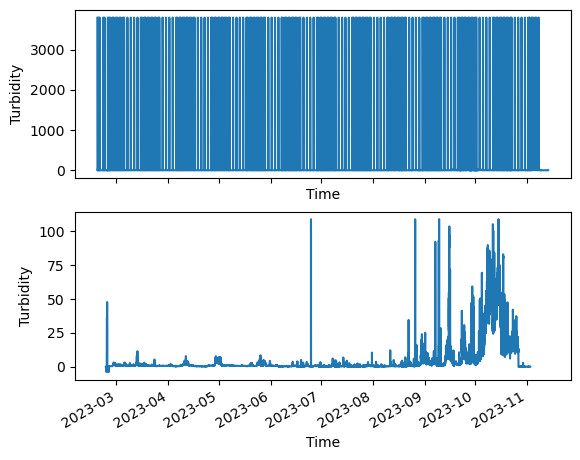

In [10]:
# Plot unfiltered turbidity timeseries from Seapoint sensors on NSIF and MFN
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
tuNSIF.plot.line(ax=axs[0])
tuMFN.plot.line(ax=axs[1])

The turbidity from the NSIF Seapoint Turbidity sensor has data values greater than the expected range of the sensor, so we will apply a simple mask for values greater than 25 NTU (expected 0-25 NTU) to resolve the majority of the measured values in the time series. The expected range for the sensor on the NSIF referenced here is pulled from the At-Sea Test 3 Plan document. The Seapoint Turbidity sensor data sheet indicates that the maximum FTU (used in data sheet) value is only 4000 when gain is set to 1x. Gain should have been set to 100x for maximum readings of 25 FTU. The Deployment Info screenshot on the raw data repo shows that the sensor range was set to 25 NTU.

In [11]:
# Mask turbidity values from NSIF Seapoint over 25 NTU
tuNSIF25 = tuNSIF.where(tuNSIF <= 25)

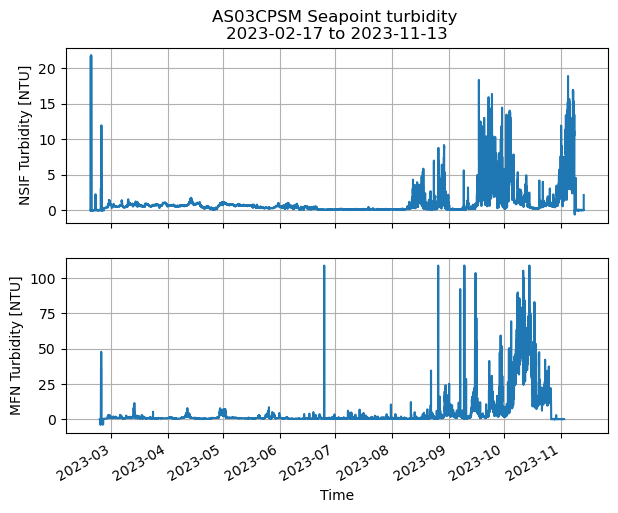

In [26]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
tuMFN.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity \n{tuNSIF25["Time"][0].values:.10} to {tuNSIF25["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_turbidity_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Plot Seapoint turbidity in July with smaller turbidity range

In [32]:
# Select Seapoint turbidity measured in July 2023
tuNSIF25_Jul = tuNSIF25.sel(Time="July 2023")
tuMFN_Jul = tuMFN.sel(Time="July 2023")

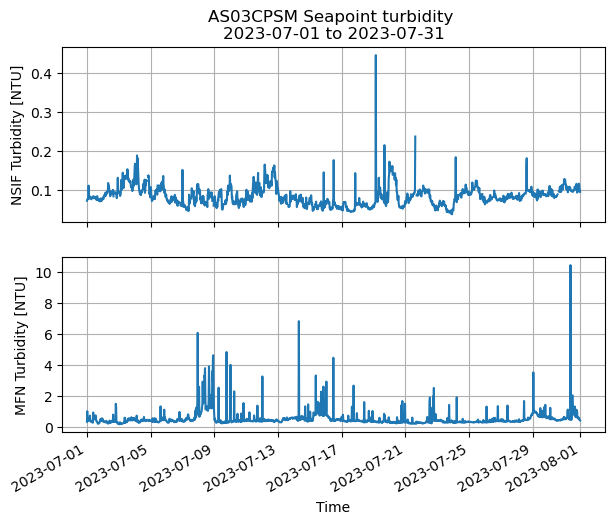

In [33]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
tuNSIF25_Jul.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
tuMFN_Jul.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity \n{tuNSIF25_Jul["Time"][0].values:.10} to {tuNSIF25_Jul["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_turbidity_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Apply a median smoothing filter to Seapoint turbidity

In [34]:
# Use rolling window object for a 6-hour median smoothing filter
tuNSIFmedian_Jul = tuNSIF25_Jul.rolling(Time=12, center=True).median()
tuMFNmedian_Jul = tuMFN_Jul.rolling(Time=12, center=True).median()

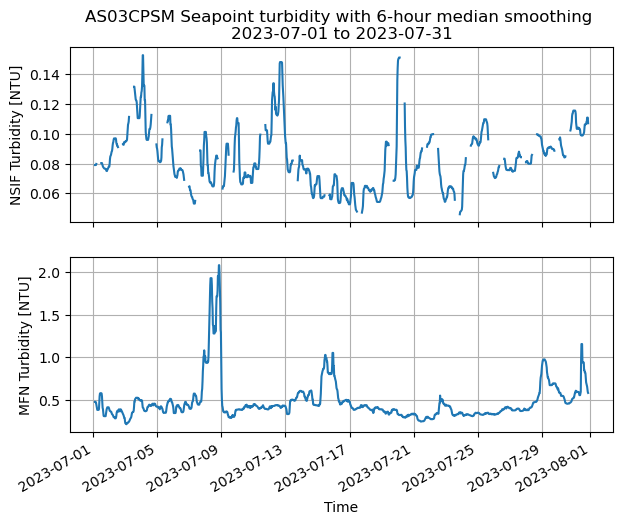

In [36]:
# Plot median-smoothed NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
tuNSIFmedian_Jul.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
tuMFNmedian_Jul.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity with 6-hour median smoothing \n{tuNSIFmedian_Jul["Time"][0].values:.10} to {tuNSIFmedian_Jul["Time"][-1].values:.10}')
plt.savefig('figures/AS03CPSM_turbidity_6hrmedian_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

### Compare recovered instrument turbidity with FLORT and shipboard transmissometers

In [5]:
# need to donwload FLORT recovered host files for dates only during AST3 deployment
# following a couple tutorials to figure out how to do this in parallel
def is_valid(url):
    """ Checks whether URL is valid
    """
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)

def get_file_urls(url: str, instr: str, start_date: int, end_date: int):
    """ Returns URLS to any .log files on the page.
    """
    soup = bs(requests.get(url).content, "html.parser")
    urls = []
    for log in tqdm(soup.find_all("a", string=re.compile(instr+".log\Z")), "Finding logger files"):
        log_url = log.attrs.get("href")
        if int(log_url[:8]) >= start_date and int(log_url[:8]) <= end_date:
            log_url = urljoin(url, log_url)
            if is_valid(log_url):
                urls.append(log_url)
        else:
            continue

    return urls

In [6]:
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/"

In [16]:
# Set up file URL request with start and end dates from quick look cruise reports
files = get_file_urls(url, instr="flort1", start_date=20230224, end_date=20231026)
files

Finding logger files: 100%|██████████| 308/308 [00:00<00:00, 25572.49it/s]


['https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230224.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230225.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230226.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230227.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230228.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230301.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230302.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230303.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230304.flort1.log',
 

In [17]:
with ThreadPoolExecutor() as executor:
    executor.map(download_file, files)

Downloaded file 20230227.flort1.log
Downloaded file 20230319.flort1.log
Downloaded file 20230314.flort1.log
Downloaded file 20230304.flort1.log
Downloaded file 20230309.flort1.log
Downloaded file 20230226.flort1.log
Downloaded file 20230305.flort1.log
Downloaded file 20230303.flort1.log
Downloaded file 20230318.flort1.log
Downloaded file 20230228.flort1.log
Downloaded file 20230308.flort1.log
Downloaded file 20230313.flort1.log
Downloaded file 20230310.flort1.log
Downloaded file 20230315.flort1.log
Downloaded file 20230320.flort1.log
Downloaded file 20230321.flort1.log
Downloaded file 20230323.flort1.log
Downloaded file 20230322.flort1.log
Downloaded file 20230324.flort1.log
Downloaded file 20230224.flort1.log
Downloaded file 20230312.flort1.log
Downloaded file 20230325.flort1.log
Downloaded file 20230327.flort1.log
Downloaded file 20230306.flort1.log
Downloaded file 20230301.flort1.log
Downloaded file 20230328.flort1.log
Downloaded file 20230311.flort1.log
Downloaded file 20230326.flo

In [ ]:
def load_flort_df(savepath, files):
    """ From URLS and local save path, opens FLORT logger files
    and loads data into a pandas data frame.
    """
    df = pd.DataFrame()
    for file in files:
        loadpath = "/".join([savepath, file.split("/")[-1]])
        df_chunk = pd.read_csv(loadpath, sep=" ", header=None, )
        df = df.join(df_chunk)